In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import os
import h5py
from scipy.fft import fft, fftfreq
from scipy.optimize import curve_fit
import Modules.data_analysis as da
from Modules.HDF5manager import HDF5
import time
from tqdm import tqdm, trange
from numba import njit

COLORS = ['orangered', 'deepskyblue', 'yellowgreen', 'darkviolet']
LINESTYLES = ['solid', 'dotted', 'dashed', 'dashdot']

# Polarization of the Lamp

In [2]:
path = './Experiments/Lamp Polarization/2022.01.14 Lamp Stokes Vectors.hdf5'
exp = da.DataAnalyzer(path, verbose=True, force_calculation=False)

14:17    Opened file 2022.01.14 Lamp Stokes Vectors.hdf5

File metadata:
hierarchy:  One group per filter. Each group has N datasets of shape [positions,polarizer_angles,x,y,3], with N being set by parameter "repeats". Positions and angle_polarizer (in degrees) embedded as list in metadata of dataset with keys "positions" and "angle_polarizer".
polarization_definition:  linear polarizer: 0 is vertical quarter lambda plate: 0 is horizontal fast axis.
readme:  
sample_angle:  90.0
user:  Naor Scheinowitz

Groups:
No filter

Datasets of group "No filter":
Frames 0
Frames 1
Frames 10
Frames 11
Frames 12
Frames 13
Frames 14
Frames 2
Frames 3
Frames 4
Frames 5
Frames 6
Frames 7
Frames 8
Frames 9
Frames combined
dark frame 0

Metadata of group "No filter":
bounds:  [180 180]
date:  2022.01.14
median:  True
nframes:  50
repeats:  15
software_verion:  0.6
step_size:  5
14:17    Corrected file already exists. Switching to it.
14:17    Opened file 2022.01.14 Lamp Stokes Vectors corrected.hdf5
14:

In [4]:
exp.f.print_structure()


File metadata:
hierarchy:  One group per filter. Each group has N datasets of shape [positions,polarizer_angles,x,y,3], with N being set by parameter "repeats". Positions and angle_polarizer (in degrees) embedded as list in metadata of dataset with keys "positions" and "angle_polarizer".
polarization_definition:  linear polarizer: 0 is vertical quarter lambda plate: 0 is horizontal fast axis.
readme:  
sample_angle:  90.0
user:  Naor Scheinowitz

Groups:
No filter

Datasets of group "No filter":
Frames
Frames_err
Stokes_frames
Stokes_frames_error
Stokes_frames_normalized
Stokes_frames_normalized_error
Stokes_frames_rgb
Stokes_frames_rgb_error
Stokes_frames_rgb_normalized
Stokes_frames_rgb_normalized_error
Stokes_vectors
Stokes_vectors_error
angles_out
polarizer_angles

Metadata of group "No filter":
binning:  [1 1]
bounds:  [180 180]
color_mode:  rgb8p
date:  2022.01.14
exposure:  8.36e-05
frame_format:  list
frame_info_format:  namedtuple
frame_info_period:  1
frame_period:  0.020398

In [4]:
# Prepare data arrays
group = exp.f.group('No filter')
theta = group['polarizer_angles'][:]
frames = group['Frames'][0]
frames_err = group['Frames_err'][0]

intensity, error = frames.sum(axis=(1, 2, 3)), frames_err.sum(axis=(1, 2, 3))
norm = intensity.mean()
intensity, error = intensity/norm, error/norm
print(frames.shape, '-->', intensity.shape)

stokes_vector, stokes_err = da.calc_stokes_params(intensity, error, theta)
norm = stokes_vector[0]
stokes_vector = np.array(stokes_vector)
stokes_err = np.array(stokes_err)
expected, theta2 = da.DataPlotter.intensity_curve(stokes_vector)

Stokes_formatted = f'Calculated Stokes Vector \nS={tuple(np.round(stokes_vector/norm,3))}\n'\
r'$\pm$'\
f'{tuple(np.round(stokes_err/norm,4))}'

print(Stokes_formatted)

(60, 200, 200, 3) --> (60,)
Calculated Stokes Vector 
S=(1.0, -0.0, 0.001, 0.001)
$\pm$(0.0026, 0.0005, 0.0005, 0.0002)


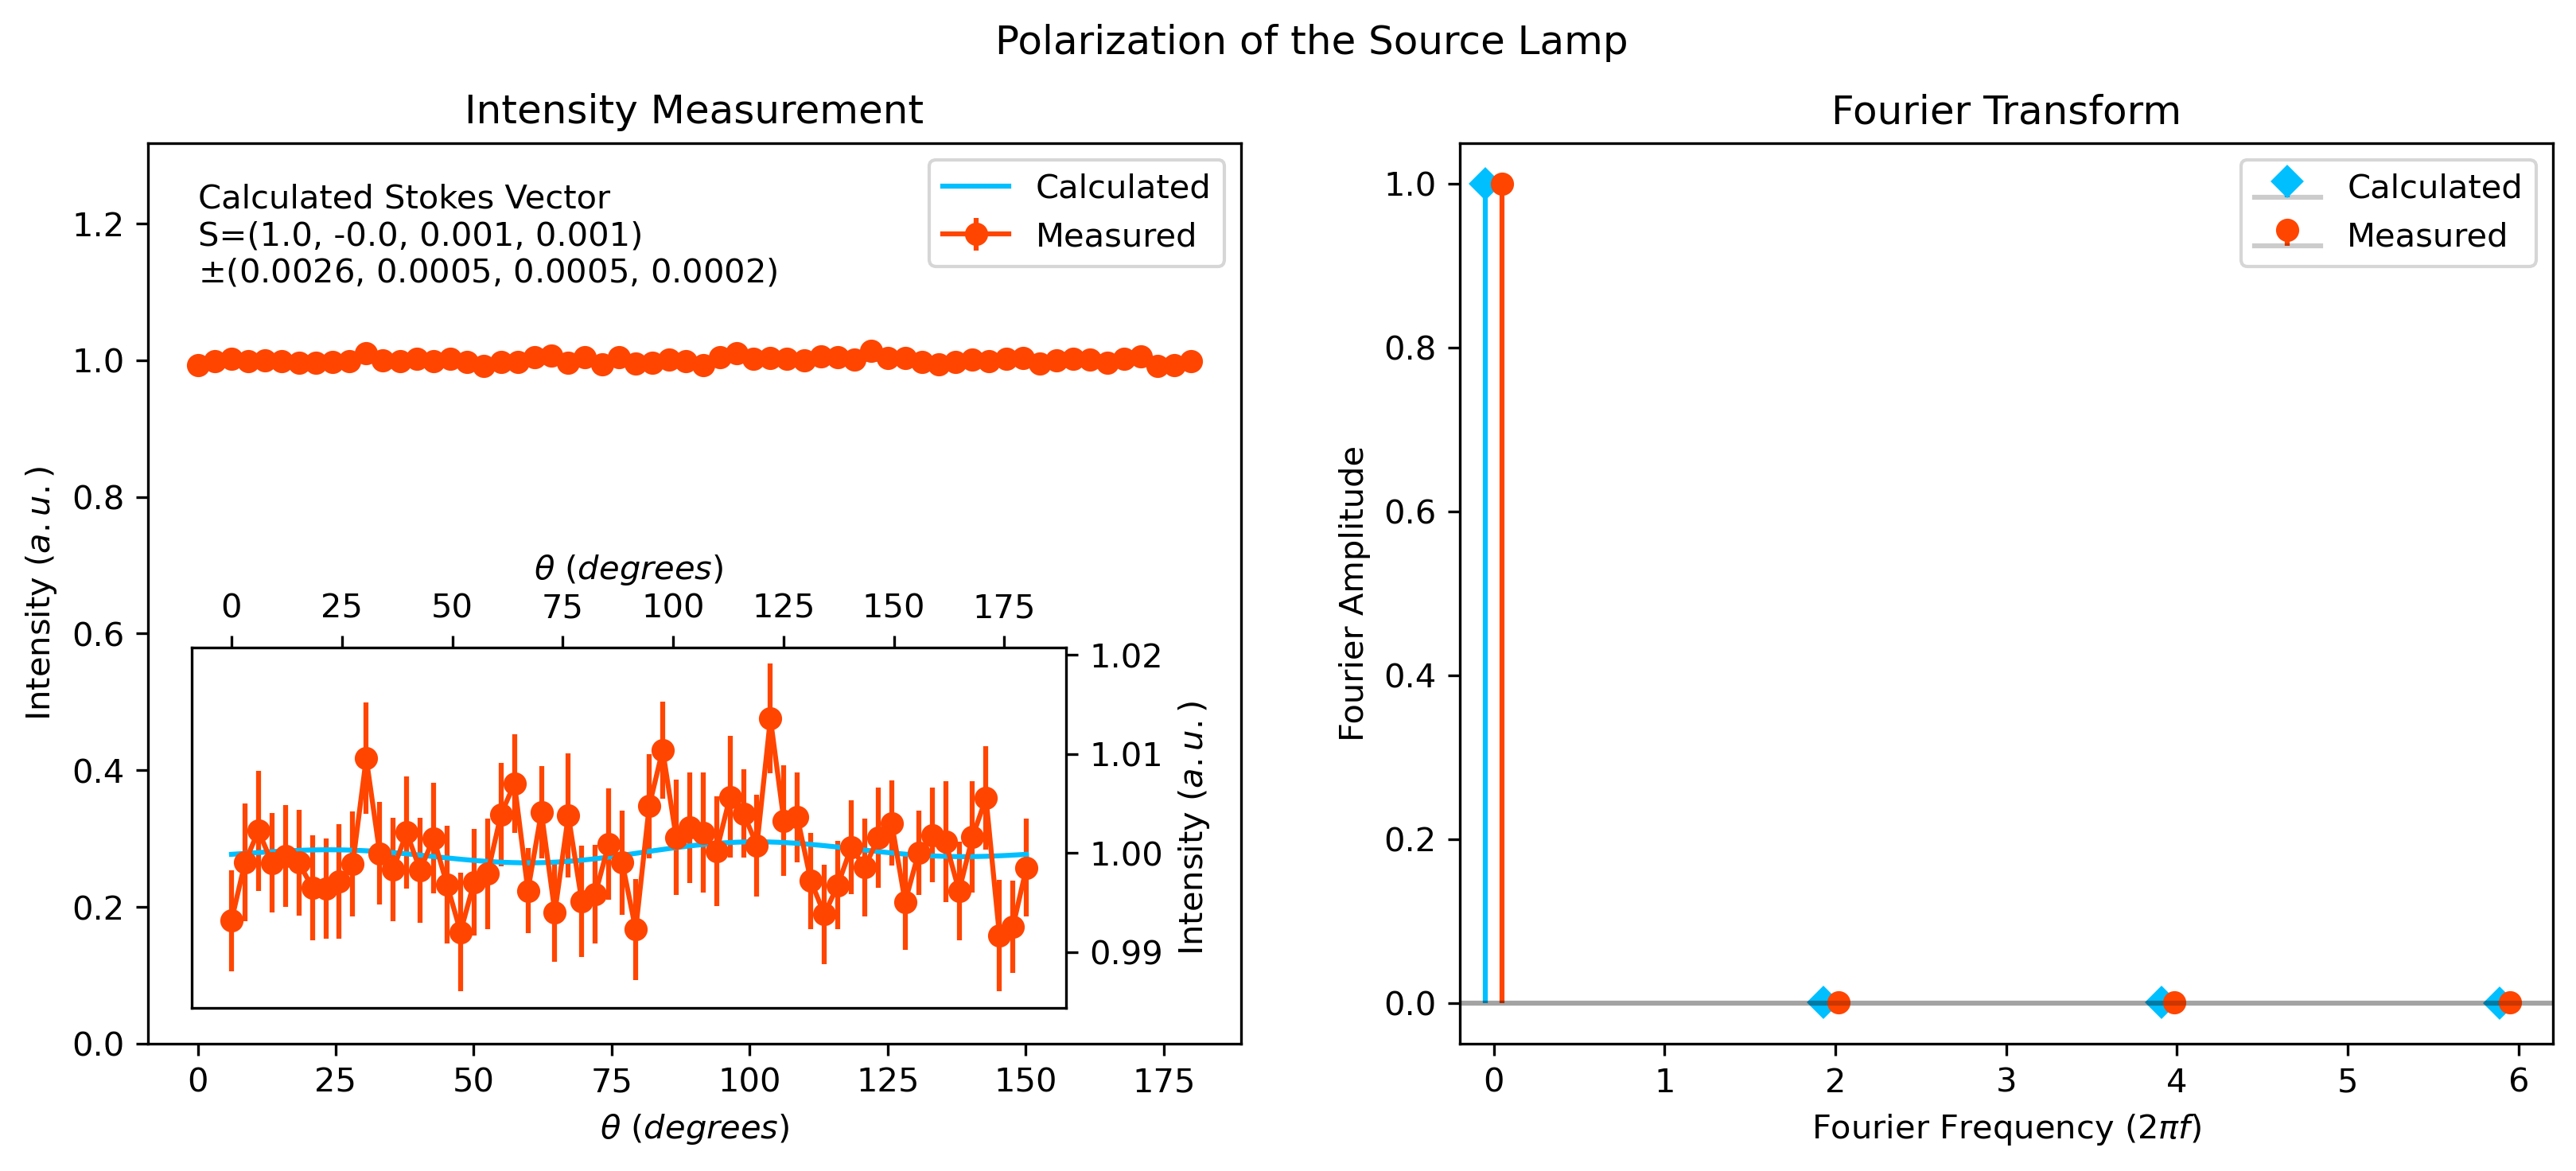

In [16]:
# Plotting
fig, ax = plt.subplots(ncols=2, figsize=(13,5), dpi=300)
fig.suptitle('Polarization of the Source Lamp')


# Left plot: angle domain
axins = ax[0].inset_axes([0.04, 0.04, 0.8, 0.4])
for i in [ax[0],axins]:
    i.errorbar(
        theta, intensity, yerr=error, 
        marker='o', ls=None, label='Measured', color=COLORS[0])
    i.plot(theta2, expected, 
               color=COLORS[1], label='Calculated')

# Aesthetics
ax[0].legend(loc='upper right')
ax[0].set_ylim(0, intensity.max() * 1.3)
#ax[0].indicate_inset_zoom(axins, edgecolor="black", alpha=0.8)
ax[0].set_xlabel(r'$\theta$ ($degrees$)')
ax[0].set_ylabel('Intensity ($a.u.$)')
ax[0].set_title('Intensity Measurement')
axins.set_ylabel('Intensity ($a.u.$)')
axins.set_xlabel(r'$\theta$ ($degrees$)')
axins.xaxis.set_label_position('top') 
axins.xaxis.tick_top()
axins.yaxis.set_label_position('right') 
axins.yaxis.tick_right()
ax[0].text(0.04, intensity.max()*1.1, Stokes_formatted)


# Right plot: fourier transform
# Stokes vector FFT
N = len(expected)
dt = (theta2[1] - theta2[0])
fourier = fft(expected)
norm = fourier.max()
freq = fftfreq(N, dt) * 360 - 0.05
markerline, stemlines, baseline = ax[1].stem(
    freq, np.abs(fourier / norm), 
    markerfmt='D', label='Calculated')
markerline.set_color(COLORS[1])
stemlines.set_color(COLORS[1])
baseline.set_color(COLORS[1])
markerline.set_alpha(1)
#markerline.set_markerfacecolor('none')
stemlines.set_alpha(1)
baseline.set_alpha(0.2)
baseline.set_color('black')

N = len(intensity)
dt = (theta[1] - theta[0])
fourier = fft(intensity)
norm = fourier.max()
freq = fftfreq(N, dt) * 360 + 0.05
markerline, stemlines, baseline = ax[1].stem(
    freq, np.abs(fourier / norm), 
    label='Measured')
markerline.set_color(COLORS[0])
#markerline.set_markerfacecolor('none')
stemlines.set_color(COLORS[0])
baseline.set_color('black')
markerline.set_alpha(1)
stemlines.set_alpha(1)
baseline.set_alpha(0.2)

# Aesthetics
ax[1].set_title('Fourier Transform')
ax[1].legend(loc='upper right')
ax[1].set_xlim(-0.2, 6.2)
ax[1].set_xlabel(r'Fourier Frequency ($2\pi f$)')
ax[1].set_ylabel('Fourier Amplitude')

plt.savefig('Lamp Polarization',transparent=False, bbox_inches='tight')
plt.show()
plt.close(fig)

# Simulated Stokes Vector Fourier Transform

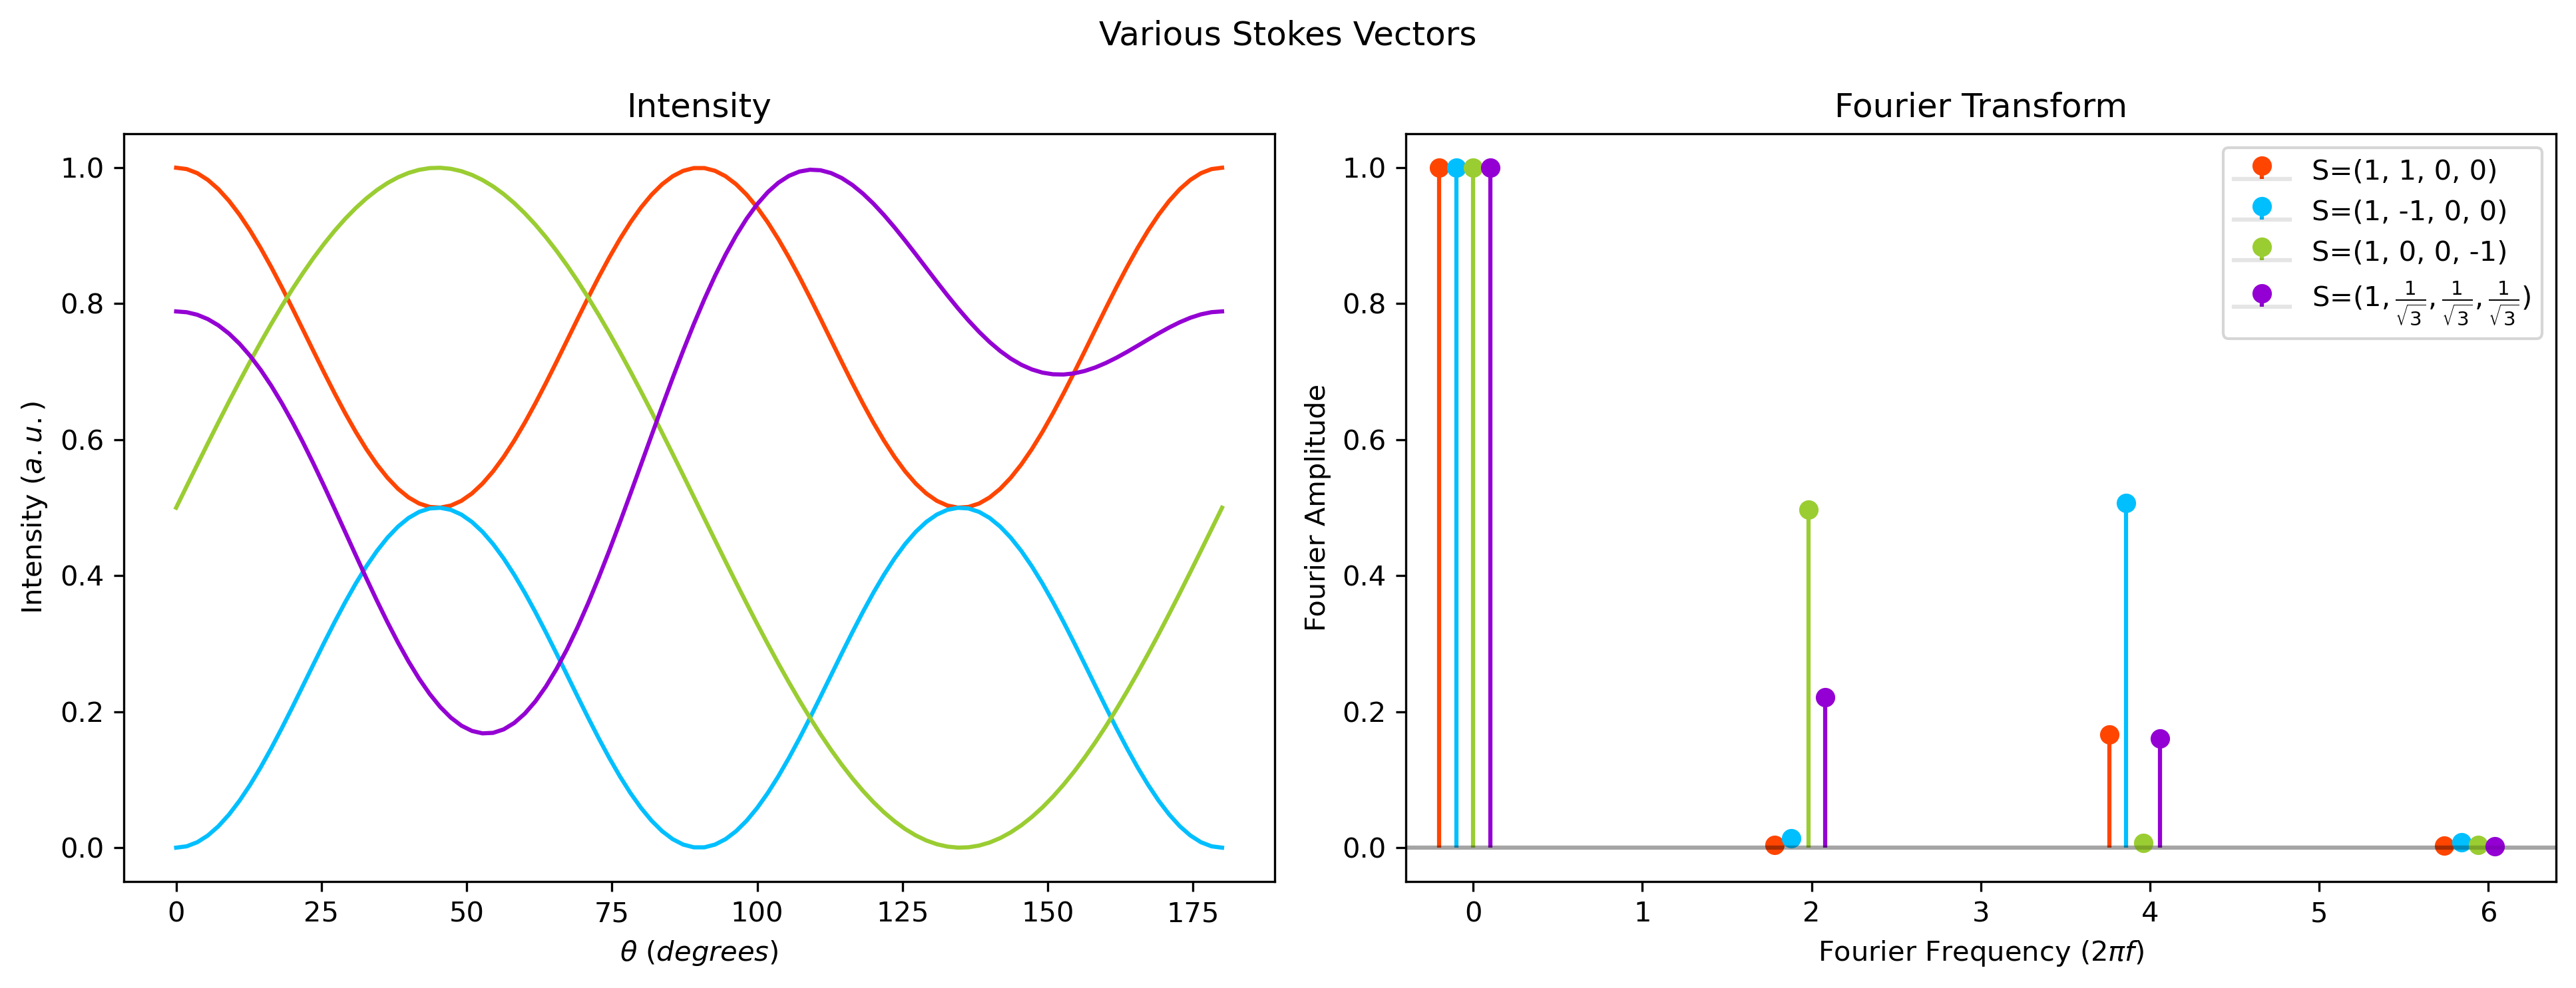

In [17]:
fig, ax = plt.subplots(ncols=2, figsize=(13,5), dpi=300)
fig.suptitle('Various Stokes Vectors')

for index, vector in enumerate([[1,1,0,0], [1,-1,0,0], [1,0,0,-1], [1,1/np.sqrt(3),1/np.sqrt(3),1/np.sqrt(3)]]):
    N = 100
    intensity, theta = da.DataPlotter.intensity_curve(vector, N)
    if vector == [1,1/np.sqrt(3),1/np.sqrt(3),1/np.sqrt(3)]:
        #Stokes_formatted = r'S=$(1, 1/\sqrt{3}, 1/\sqrt{3}, 1/\sqrt{3})$'
        Stokes_formatted = r'S=$(1, \frac{1}{\sqrt{3}}, \frac{1}{\sqrt{3}}, \frac{1}{\sqrt{3}})$'
    else:
        Stokes_formatted = f'S={tuple(vector)}'
    
    # Left plot: angle domain
    ax[0].plot(
        theta, intensity,
        marker=None, label=Stokes_formatted, color=COLORS[index])

    # Aesthetics
    ax[0].set_xlabel(r'$\theta$ ($degrees$)')
    ax[0].set_ylabel('Intensity ($a.u.$)')
    ax[0].set_title('Intensity')
    

    # Right plot: fourier transform
    dt = (theta[1] - theta[0])
    fourier = fft(intensity)
    norm = fourier.max()
    freq = fftfreq(N, dt) * 360 + index * 0.1 - 0.2
    markerline, stemlines, baseline = ax[1].stem(
        freq, np.abs(fourier / norm), 
        label=Stokes_formatted)
    markerline.set_color(COLORS[index])
    #markerline.set_markerfacecolor('none')
    stemlines.set_color(COLORS[index])
    baseline.set_color('black')
    alpha = 1
    markerline.set_alpha(alpha)
    stemlines.set_alpha(alpha)
    baseline.set_alpha(0.1)

    # Aesthetics
    ax[1].set_title('Fourier Transform')
    ax[1].legend(loc='upper right')
    ax[1].set_xlim(-0.4, 6.4)
    ax[1].set_xlabel(r'Fourier Frequency ($2\pi f$)')
    ax[1].set_ylabel('Fourier Amplitude')

    #fig.tight_layout()

plt.savefig('Stokes examples.png', transparent=False, bbox_inches='tight')
fig.tight_layout()
plt.show()
plt.close(fig)

# Light intensity variation in time

In [7]:
path = './Experiments/Median Test/2022.02.15 Median test - Beetle.hdf5'
path2 = './Experiments/Median Test/2021.12.15 Median test - S polarization large set .hdf5'
long = HDF5(path, 'open')
short = HDF5(path2, 'open')

16:06    Opened file ./Experiments/Median Test/2022.02.15 Median test - Beetle.hdf5
16:06    Opened file ./Experiments/Median Test/2021.12.15 Median test - S polarization large set .hdf5


In [10]:
short.print_structure()
print(short.file['Frames 0'].shape)
print(long.file['Frames 0'].shape)
print(short.file['Frames 0'].attrs['frame_period'])
print(long.file['Frames 0'].attrs['frame_period'])
print(long.file['Frames 0'].attrs['exposure'])


File metadata:
date:  2021.12.15
dt:  10
hierarchy:  No groups. Datasets of shape [nframes,x,y,3]
median:  False
nframes:  200
polarization:  0
polarization_definition:  0 is vertical (S) polarization
readme:  Measuring how much single measurement varies over time due to lamp to get brightness distribution of lamp.
repeats:  20
software_verion:  0.6
user:  Naor Scheinowitz

Groups:
Frames 0
Frames 1
Frames 10
Frames 11
Frames 12
Frames 13
Frames 14
Frames 15
Frames 16
Frames 17
Frames 18
Frames 19
Frames 2
Frames 3
Frames 4
Frames 5
Frames 6
Frames 7
Frames 8
Frames 9

Datasets of group "Frames 0":


AttributeError: 'Dataset' object has no attribute 'keys'

In [15]:
# Load data from hdf5 file
data = long.file['Frames 0']
exposure_long = data.attrs['exposure']
frames = data[:]
intensity_long = frames.sum(axis=(1,2,3))
intensity_long = intensity_long / intensity_long.mean()

intensity_short = []
for frame in short.file:
    data = short.file[frame]
    frames = data[:]
    intensity = frames.sum(axis=(1,2,3))
    if len(intensity_short) == 0:
        norm = intensity.mean()
    intensity = intensity / norm
    intensity_short.append(intensity)
intensity_short = np.array(intensity_short).flatten()
exposure_short = data.attrs['exposure']

In [20]:
# Calculate histogram data
def simple_gauss(x, mean, sigma):
    first_term = 1 / (sigma * np.sqrt(2 * np.pi))
    second_term = np.exp(-0.5 * (x - mean)**2 / sigma**2)
    return first_term * second_term

bin_edges = []
bin_centres = []
params = []
errors = []
intensities = [intensity_short, intensity_long]
gues = []
for intensity in intensities:
    bins = int(np.sqrt(intensity.size))
    hist, edges = np.histogram(intensity, bins, density=True)
    bin_edges.append(edges)
    centres = edges[1:] - np.diff(edges)[0]/2
    bin_centres.append(centres)

    guess = [np.mean(intensity), np.std(intensity)]
    gues.append(guess)
    popt, pcov = curve_fit(simple_gauss, centres, hist, p0=guess)
    params.append(popt)
    errors.append(np.sqrt(np.diag(pcov)))

    print(f'Guess = {guess}')
    print(f'Fit gives mean = {popt[0]} +- {np.sqrt(np.diag(pcov))[0]}\n'
          + f'sigma = {popt[1]} +- {np.sqrt(np.diag(pcov))[1]}\n\n')

Guess = [1.0004260384474526, 0.03862938951783458]
Fit gives mean = 0.9849147318383823 +- 0.00030763945761147087
sigma = 0.006322337166190142 +- 0.0002538691867352315


Guess = [0.9999999999999997, 0.0018088493175059319]
Fit gives mean = 0.9998148068986252 +- 0.00016743150954634384
sigma = 0.0019459460541425438 +- 0.0001388054148190357




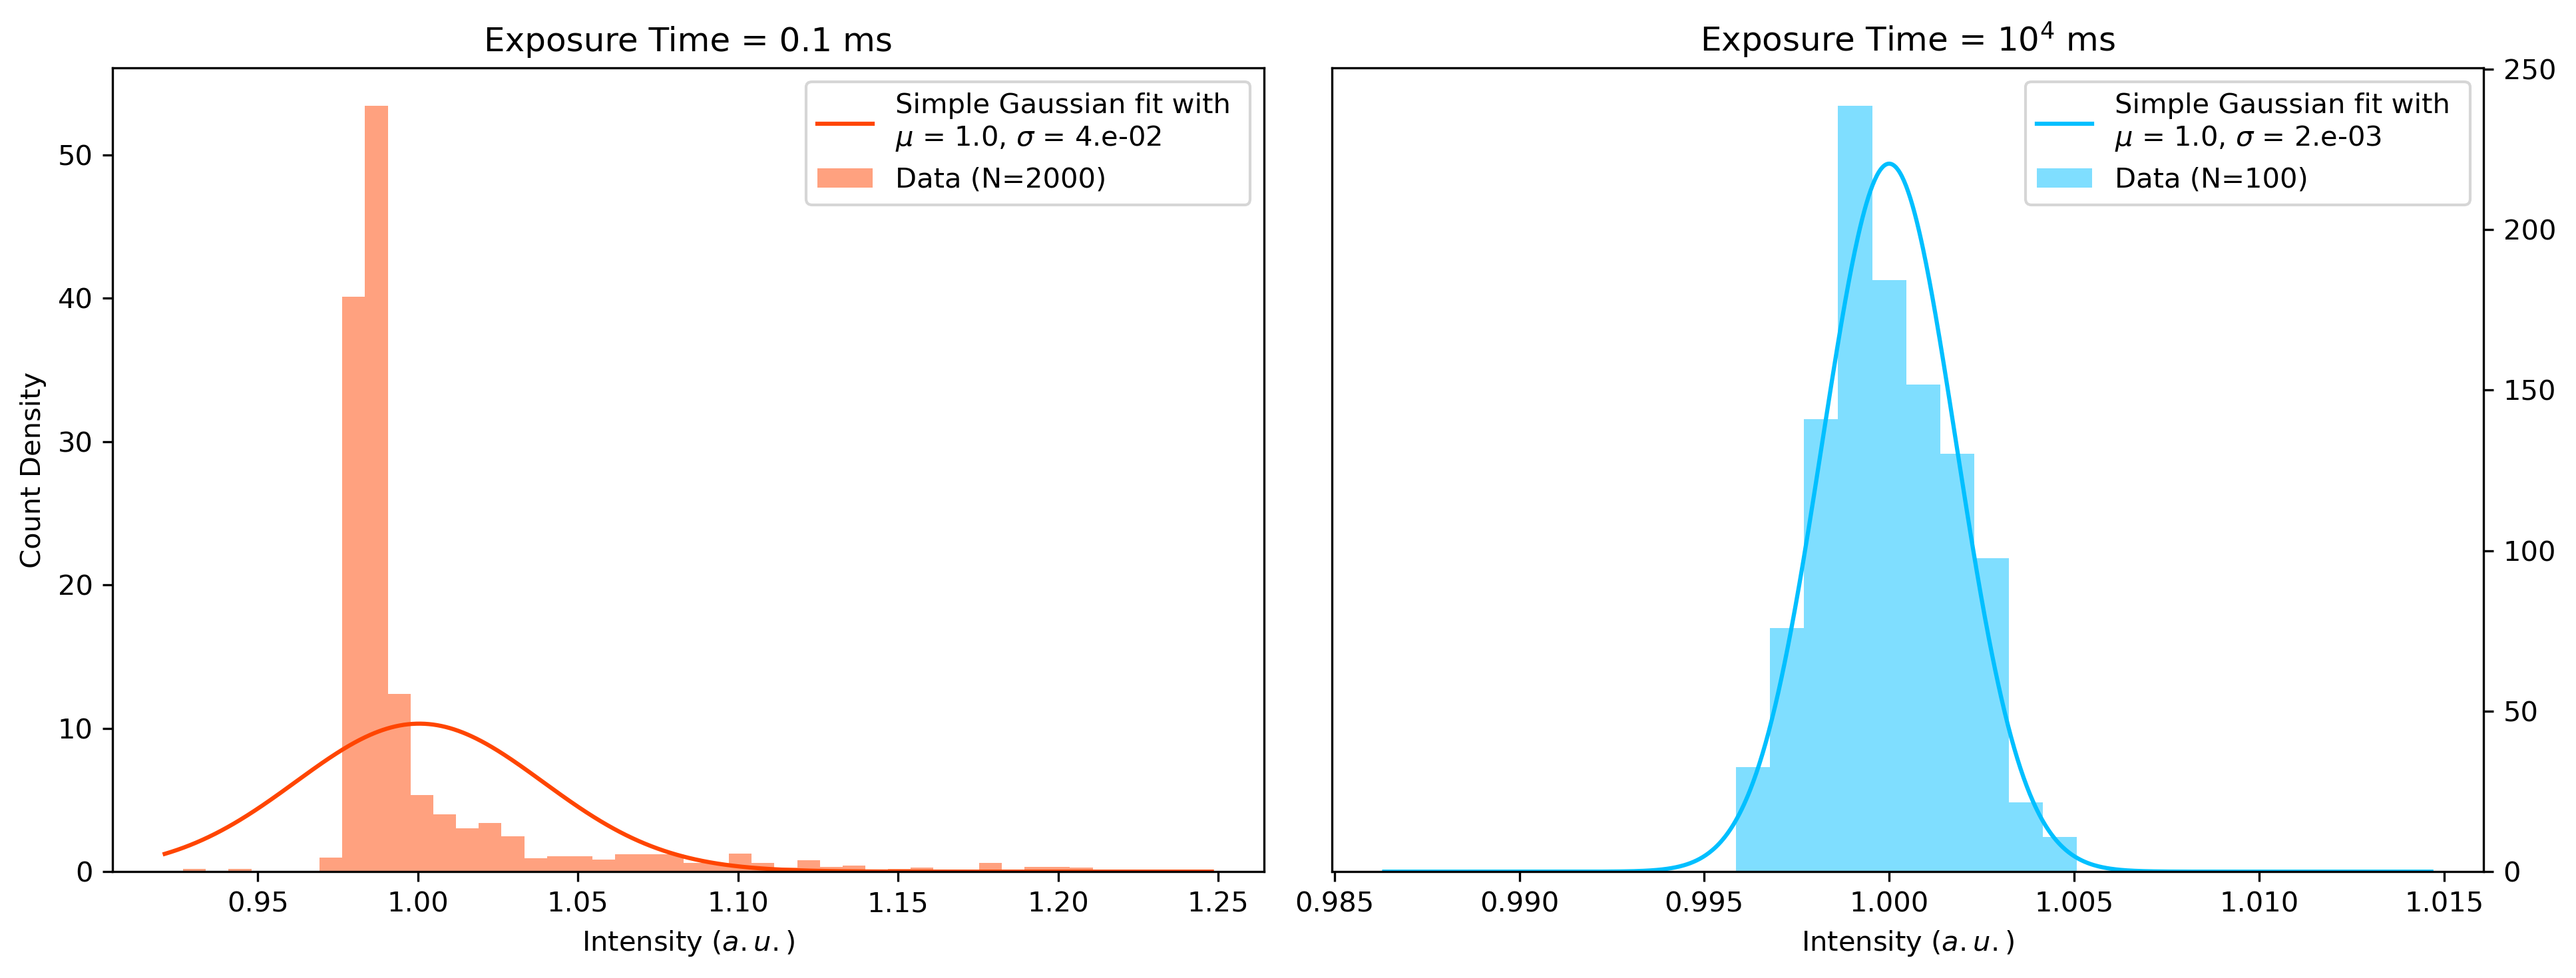

In [24]:
# Plotting
fig, ax = plt.subplots(ncols=2, dpi=300, figsize=(13,5))

labels = [f'Exposure Time = {np.round(exposure_short*1000,1)} ms', 
          r'Exposure Time = $10^4$ ms']
pres = [1, 1]
alpha = 0.5
for i in range(len(labels)):
    # Data 
    ax[i].hist(intensities[i], bins=bin_edges[i], alpha=alpha, 
            label=f'Data (N={intensities[i].size})', density=True, color=COLORS[i], log=False)
    # Fit
    x = np.linspace(bin_centres[i][0]*0.99, bin_centres[i][-1]*1.01, 1000)
    gausslabel = 'Gaussian fit with \n' \
                fr'$\mu$ = {np.round(params[i][0],pres[i])} $\pm$ {np.format_float_scientific(errors[i][0],0)} ' + '\n'\
                fr'$\sigma$ = {np.format_float_scientific(params[i][1],0)} $\pm$ {np.format_float_scientific(errors[i][1],0)}'
    gausslabel = 'Simple Gaussian fit with \n' \
                fr'$\mu$ = {np.round(gues[i][0],pres[i])}, '\
                fr'$\sigma$ = {np.format_float_scientific(gues[i][1],0)}'
    #ax[i].plot(x, simple_gauss(x, *params[i]), color=COLORS[i], label=gausslabel)
    ax[i].plot(x, simple_gauss(x,*gues[i]), color=COLORS[i], label=gausslabel)
    ax[i].legend()
    ax[i].set_xlabel(r'Intensity ($a.u.$)')
    ax[i].set_ylabel('Count Density')
    ax[i].set_title(labels[i])


ax[1].yaxis.set_label_position('right') 
ax[1].yaxis.tick_right()
ax[1].set_ylabel('')
fig.tight_layout()
plt.savefig('Lamp variation.png', transparent=False, bbox_inches='tight')
plt.show()

# Angle v Stokes parameters

In [2]:
f = HDF5(path, 'read only')

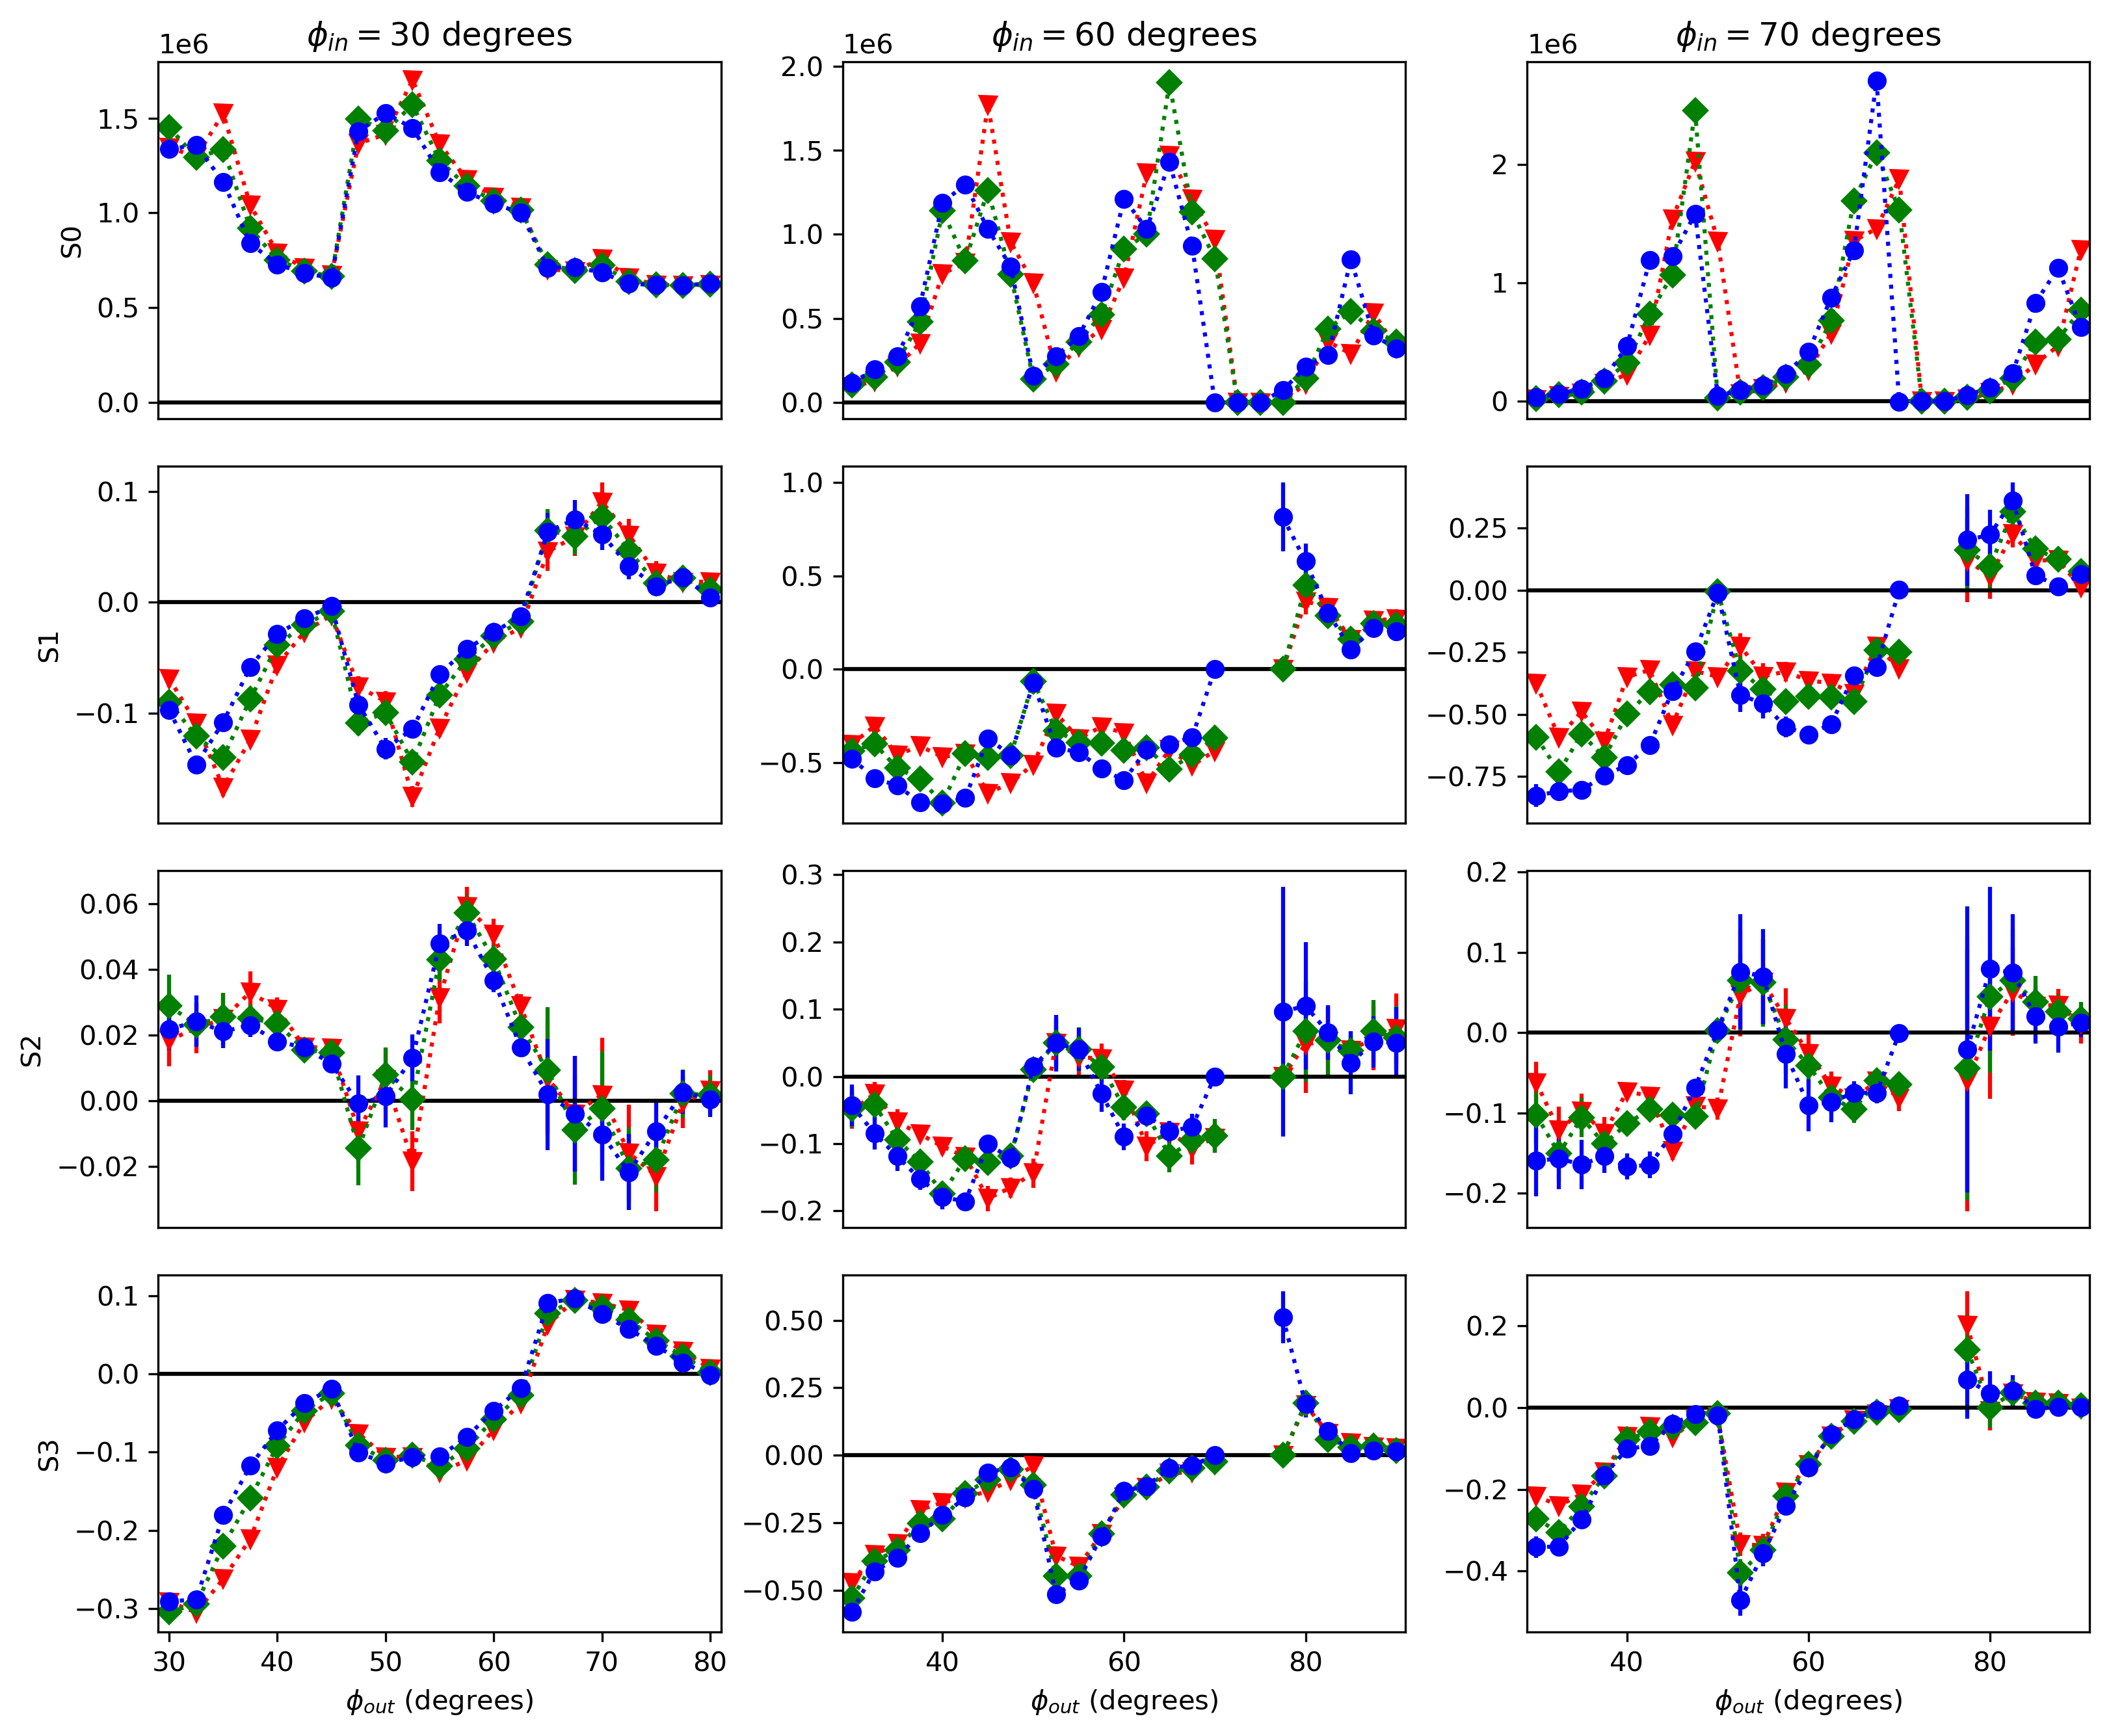

15:44    Closed file /Volumes/physics/Master Projects/Beetle Project/Beetle Classifier Robot/Experiments/2022.01.19 Beetle reflection spot corrected/2022.01.19 Beetle reflection spot corrected.hdf5 because of __exit__ call.


In [29]:
path = '/Volumes/physics/Master Projects/Beetle Project/Beetle Classifier Robot/Experiments/2022.01.19 Beetle reflection spot corrected/2022.01.19 Beetle reflection spot corrected.hdf5'
with HDF5(path, 'read only') as f:
    fig, ax = plt.subplots(nrows=4,ncols=3, dpi=300, figsize=(11,9))

    for i, r in enumerate(f.file):
        group = f.group(r)
        data = group['Stokes_vectors'][:]
        error = group['Stokes_vectors_error'][:]
        angles = group.attrs['angles_out']
        da.DataPlotter.stokes_vs_angle(data, angles, error, ax=ax[:,i])
        ax[0, i].set_title(r'$\phi_{in}=$' + str(r[:2]) + ' degrees')
        ax[0, i].get_legend().remove()
        ax[3, i].set_xlabel(r'$\phi_{out}$ (degrees)')
        if i > 0:
            for a in range(4):
                ax[a, i].set_ylabel('')

    fig.tight_layout()
    loc = '/Users/naorscheinowitz/Master Project/Beetle Project/Thesis/Figures/stokes vs angle.png'
    fig.savefig(loc, bbox_inches='tight')
    plt.show()
    plt.close(fig)

15:43    Opened file /Volumes/physics/Master Projects/Beetle Project/Beetle Classifier Robot/Experiments/2022.02.23 Beetle Hyperspectral - maximal exposure corrected/2022.02.23 Beetle Hyperspectral - maximal exposure corrected.hdf5


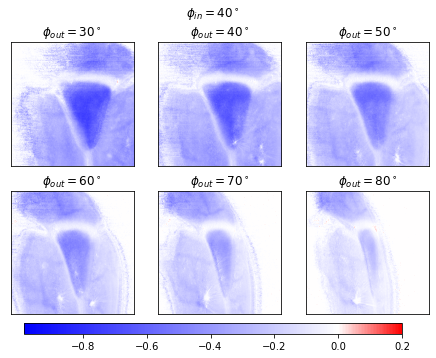

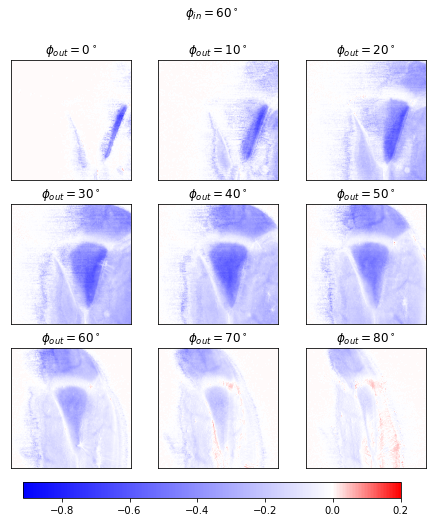

15:44    Closed file /Volumes/physics/Master Projects/Beetle Project/Beetle Classifier Robot/Experiments/2022.02.23 Beetle Hyperspectral - maximal exposure corrected/2022.02.23 Beetle Hyperspectral - maximal exposure corrected.hdf5 because of __exit__ call.


In [28]:
path = '/Volumes/physics/Master Projects/Beetle Project/Beetle Classifier Robot/Experiments/2022.02.23 Beetle Hyperspectral - maximal exposure corrected/2022.02.23 Beetle Hyperspectral - maximal exposure corrected.hdf5'
roi = (slice(150,950), slice(150,950))
with HDF5(path, 'open') as f:
    for grp in f.file:
        group = f.group(grp)
        frames = group['Stokes_frames_normalized'][:]
        angles = group['angles_out'][:]
        nframes = len(frames)
        ncols = 3
        nrows = np.floor(nframes/ncols).astype(int)
        #size = (nrows/ncols) * 2
        fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*2.5, nrows*2.5))
        
        vmin = np.min(frames[:,:,:,3])
        vmax = 0.2#np.max(frames[:,:,:,3]) * 0.5
        
        #Creating the cmap
        colors = ["blue", "white", "red"]

        nodes = [0.0, 1-(vmax/(vmax-vmin)), 1.0]
        cmap = LinearSegmentedColormap.from_list("mycmap", list(zip(nodes, colors)))
        
        while nframes%ncols != 0:
            nframes -= 1
            frames = frames[1:]
            angles = angles[1:]
            
        for i, frame in enumerate(frames):
            row = np.floor(i / ncols).astype(int)
            column = i % ncols
            im = da.DataPlotter.stokes_image(frame[roi], 3, ax=ax[row, column], colorbar=False,v=(vmin,vmax),cmap=cmap)
            #ax[row, column].axes.xaxis.set_visible(True)
            #ax[row, column].xaxis.set_ticklabels([])
            #ax[row, column].tick_params(bottom = False)
            ax[row, column].set_title(r'$\phi_{out}=$' + fr'{angles[i]}$^\circ$')
            #ax[row, column].set_title('')
            
        
        #fig.subplots_adjust(bottom=0.2)
        cbar_ax = fig.add_axes([0.15,0.07,0.7,0.03])
        fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
        fig.suptitle(r'$\phi_{in}=$' + fr'{grp[:2]}$^\circ$')
        savepath = '/Users/naorscheinowitz/Master Project/Beetle Project/Thesis/Figures/'
        fig.savefig(savepath + f'S3 series {grp}.png', dpi=300, bbox_inches='tight')
        plt.show()
        plt.close(fig)
            

# Transfer dark frames to other hdf5 files

In [ ]:
path = '/Volumes/physics/Master Projects/Beetle Project/Beetle Classifier Robot/Experiments/2022.02.23 Beetle Hyperspectral - maximal exposure.hdf5'
darkpath = '/Volumes/physics/Master Projects/Beetle Project/Beetle Classifier Robot/Experiments/Beetle Hyperspectral - maximal exposure - large angle.hdf5'
x = input()
with HDF5(darkpath, 'read only') as f_dark:
    dark = f_dark.file['70 degree reflection/dark frame 0']
    with HDF5(path, 'open') as f:
        for grp in f.file:
            del f.file[grp+'/dark frame 0 0']
            f.create_dataset('dark frame', dark, parent=grp)


In [13]:
path = '/Volumes/physics/Master Projects/Beetle Project/Beetle Classifier Robot/Experiments/2022.01.19 Beetle reflection spot.hdf5'
x = input()
with HDF5(path, 'open') as f:
    f.print_structure()
    #for grp in f.file:
    #    print(f.file[grp+'/Frames combined'].attrs['roi'])
    #    #print(f.file[grp+'/Frames combined'].shape)
    #dset = f.file['30 degree reflection/Frames combined'][0,0,0]
    #print(dset.shape)
    #dset = dset[88:388, 94:394]
    #print(dset.shape)
    #dark = f.file['60 degree reflection/dark frame 0'][:]
    #f.create_dataset('dark frame', dark, parent='30 degree reflection')
    #data = f.file['30 degree reflection/Frames combined'][:,:,:, 88:388, 94:394]
    #meta = HDF5.read_metadata(f.file['30 degree reflection/Frames combined'])
    #f.create_dataset('Frames combined zoomed', data, parent='30 degree reflection', metadata=meta)


01:14    Opened file /Volumes/physics/Master Projects/Beetle Project/Beetle Classifier Robot/Experiments/2022.01.19 Beetle reflection spot.hdf5

File metadata:
angle_in:  60
hierarchy:  One group per filter. Each group has N datasets of shape [positions,polarizer_angles,x,y,3], with N being set by parameter "repeats". Positions and angle_polarizer (in degrees) embedded as list in metadata of dataset with keys "positions" and "angle_polarizer".
polarization_definition:  linear polarizer: 0 is vertical quarter lambda plate: 0 is horizontal fast axis.
readme:  Measurements with a fixed angle of incoming light and a varying angle_out. Goal is to find interesting changes in the Stokes parameters wrt reflection angle.
user:  Naor Scheinowitz

Groups:
30 degree reflection
60 degree reflection
70 degree reflection

Datasets of group "30 degree reflection":
Frames 0
Frames 1
Frames 2
Frames 3
Frames 4
Frames 5
Frames 6
Frames 7
Frames 8
Frames 9
Frames combined
Frames combined zoomed 0
dark fr

In [4]:
import numpy as np
from Modules.HDF5manager import HDF5

# Create some random data
data = np.random.randint(0, 255, (500,500))
metadata = {'meta1': 5, 'meta2': [1, 2, 3]}
with HDF5('test.hdf5', 'create', user='Naor Scheinowitz', date=True) as f:
    f.group('test group')
    dset = f.create_dataset('test set', data, parent='test group', metadata=metadata)
    HDF5.read_metadata(dset, print=True)

00:24    Created file 2022.04.12 test.hdf5
00:24    Created HDF5 group test group


meta1:  5
meta2:  [1 2 3]


00:24    Closed file 2022.04.12 test.hdf5 because of __exit__ call.
